# (Convolutional/Variational) Autoencoders

## Import Libraries

In [169]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation

# to hide warnings or atleast some of them (caused by mapping with lambda)
# the warnings are not present in colab
import logging
logging.getLogger("tensorflow").disabled = True

# select plot style
plt.style.use('fivethirtyeight')

## Load Dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

## Inspect Dataset

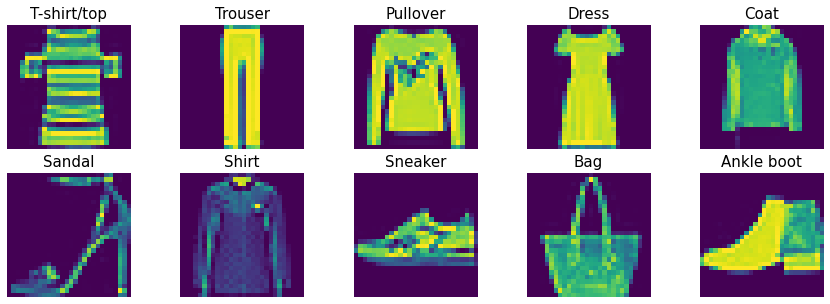

In [ ]:
# Declare which number(index) corresponds to which class
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, ax = plt.subplots(2,5,figsize=(15,5))
for label in range(10):
    idx = np.random.choice(np.where(test_labels==label)[0])
    ax[label//5,label%5].imshow(test_images[idx])
    ax[label//5,label%5].set_title(class_names[test_labels[idx]], fontsize=15)
    ax[label//5,label%5].axis("off")

## Data Pipeline

In [ ]:
# combine images and labels into a tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images.reshape(-1, 28, 28, 1))
test_dataset = tf.data.Dataset.from_tensor_slices(test_images.reshape(-1, 28, 28, 1))                                         

# create minibatches
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)


# normalize images and encode labels onehot
train_dataset = train_dataset.map(lambda image:(image/255), num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

test_dataset = test_dataset.map(lambda image: (image/255), num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

# shuffle data
train_dataset = train_dataset.shuffle(64)
test_dataset = test_dataset.shuffle(64)   

# Prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Convolutional Autoencoder

In [ ]:
from tensorflow.keras import Model, Input

class ConvAE(Model):

  def __init__(self, embedding_size = 10):
    super(ConvAE, self).__init__()

    self.encoder = [
            tf.keras.layers.Conv2D(
                              filters = 32,
                              kernel_size = 4,
                              strides = 1,
                              padding = 'same',
                              activation = 'relu',
                              input_shape = (28, 28, 1)),
         
            tf.keras.layers.Conv2D(
                              filters = 64, 
                              kernel_size = 3, 
                              strides = (2, 2), 
                              activation='relu'),
         
            tf.keras.layers.Conv2D(
                              filters = 128, 
                              kernel_size = 3, 
                              strides = (2, 2), 
                              activation ='relu'),
         
            tf.keras.layers.Flatten(),
        
            tf.keras.layers.Dense(
                              embedding_size,
                              activation = None),
        ]


    self.decoder = [
            tf.keras.layers.InputLayer(input_shape=(embedding_size)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=2, strides=1, padding='same',
                activation = "sigmoid"),
        ]
  
  # Helper function to get a nice summary with 
  # my_model.sum_helper().summary()
  # mode defines which part of the model is returned as a summary
  def sum_helper(self, mode = "encode"):
        if mode == "encode":
          x = Input(shape=(28, 28, 1))
          return Model(inputs=[x], outputs=self.call(x, mode))
        if mode == "decode":
          x = Input(shape=(10))
          return Model(inputs=[x], outputs=self.call(x, mode))


  def call(self, x, mode = None):
    
    if mode == "encode":
      for layer in self.encoder:
        x = layer(x)
      return x

    elif mode == "decode":
      for layer in self.decoder:
        x = layer(x)
      return x

    # if no mode is specified we push the input through encoder and decoder
    else:
      for layer in self.encoder:
        x = layer(x)
      for layer in self.decoder:
        x = layer(x)
      return x

## Test encoder and decoder
by pushing 5 images first through the encoder and then the decoder

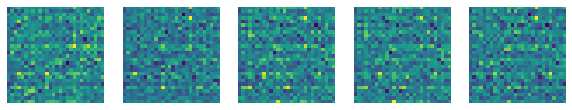

In [ ]:
model = ConvAE(10);
for img_batch in train_dataset.take(1):
    de_encoded_imgs = model(img_batch).numpy()

fig, ax = plt.subplots(1, 5, figsize=(10,10))
for index, image in enumerate(de_encoded_imgs[0:5]):
    ax[index].imshow(image.squeeze())
    ax[index].axis('off')

## Inspect Output shape of Encoder and Decoder
as expected the encoder outputs a vector <br>
with a length according to the embedding size (10)

and the decoder takes that vector and returns again an image <br>
of shape (28, 28 ,1)

In [ ]:
model.sum_helper("encode").summary()
model.sum_helper("decode").summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                46090     
Total params: 138,986
Trainable params: 138,986
Non-trainable params: 0
________________________________________________

## Define Training

In [ ]:
def train_step(model, image, loss_function, optimizer):
    with tf.GradientTape() as tape:
        reconstructed = model(image)
        loss = loss_function(image, reconstructed)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function, training = False):
    # Test over complete test data

    test_loss_aggregator = []

    for image in test_data:
        reconstructed = model(image)
        sample_test_loss = loss_function(image, reconstructed)
        test_loss_aggregator.append(np.mean(sample_test_loss.numpy()))
    
    test_loss = np.mean(test_loss_aggregator)
      
    return test_loss

## Train model and observe progress

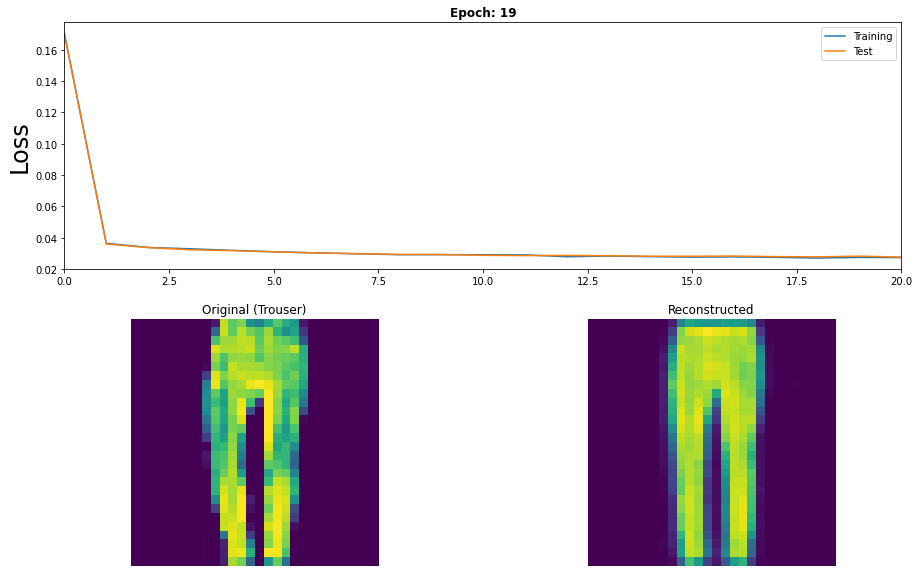

Train loss:  0.02724219089212944
Test loss:  0.02754959
CPU times: user 3min 49s, sys: 5.85 s, total: 3min 54s
Wall time: 3min 59s


In [ ]:
%%time
tf.keras.backend.clear_session()
from IPython.display import clear_output

### Hyperparameters
num_epochs = 20
learning_rate = 0.001
embedding_size = 2
running_average_factor = 0.95

model_conv = ConvAE(embedding_size)

# Initialize the loss
mean_squared_error = tf.keras.losses.MSE

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []

# Testing model performance on train and test data before learning
train_loss = test(model_conv, train_dataset, mean_squared_error)
train_losses.append(train_loss)


test_loss = test(model_conv, test_dataset, mean_squared_error)
test_losses.append(test_loss)

# Train loop for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    # Training
    running_average_loss = 0
    for image in train_dataset:
        train_loss = np.mean(train_step(model_conv, image, mean_squared_error, optimizer))
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        
    train_losses.append(running_average_loss)
   

    # Testing
    test_loss = test(model_conv, test_dataset, mean_squared_error)
    test_losses.append(test_loss)

    # each epoch we sample 1 image from out test_images
    # and compare it to the models en- and decoding
    index = np.random.choice(len(test_images))
    original = test_images[index]
    reconstructed = model_conv(np.expand_dims((original/255), axis=(0, -1))).numpy().squeeze()
    label = class_names[test_labels[index]]

    clear_output(wait=True) 
    fontsize=24

    fig = plt.figure(figsize = (15,10))

    loss_plot = fig.add_subplot(2,1,1)
    loss_plot.set_xlim((0,num_epochs))
    loss_plot.plot(train_losses,label="Training")
    loss_plot.plot(test_losses,label="Test")
    loss_plot.set_ylabel("Loss",fontsize=fontsize)
    loss_plot.set_title("Epoch: " + str(epoch), fontweight="bold")
    loss_plot.legend()

    original_plot = fig.add_subplot(2,2,3)
    original_plot.imshow(original.squeeze())
    original_plot.set_title("Original (" + label + ")")
    original_plot.axis("off")

    reconstructed_plot = fig.add_subplot(2,2,4)
    reconstructed_plot.imshow(reconstructed.squeeze())
    reconstructed_plot.set_title("Reconstructed")
    reconstructed_plot.axis("off")

    plt.show()

    print('Train loss: ',running_average_loss)
    print('Test loss: ',test_loss)


## Visualize results for each category

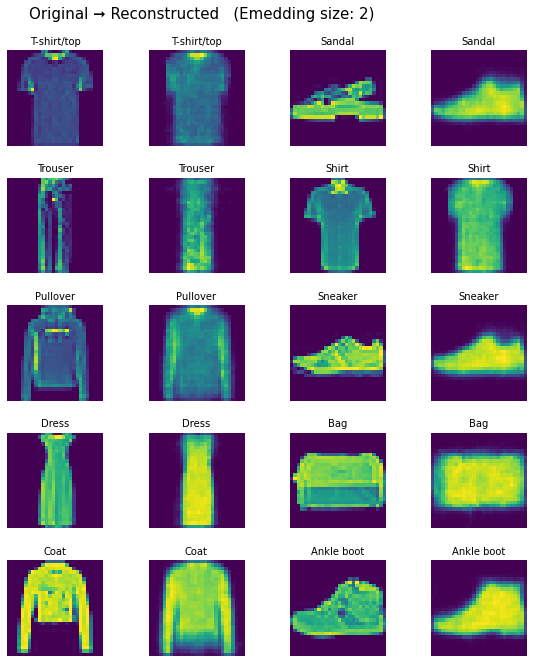

In [ ]:
fig, ax = plt.subplots(5,4,figsize=(8,20))
fig.suptitle('Original \u279e Reconstructed' + "   (Emedding size: " + str(embedding_size) + ")", fontsize=15, x = 0.40, y = 0.97)
fig.tight_layout(rect=[0, 0.5, 1, 0.95])
for cat in range(10):
    idx = np.random.choice(np.where(test_labels==cat)[0])
    ax[cat%5,0+ int(cat/5)*2].imshow(test_images[idx])
    ax[cat%5,0+ int(cat/5)*2].set_title(class_names[test_labels[idx]], fontsize=10)
    ax[cat%5,0+ int(cat/5)*2].axis("off")

    ax[cat%5,1+ int(cat/5)*2].imshow(model_conv(np.expand_dims((test_images[idx]/255), axis=(0, -1))).numpy().squeeze())
    ax[cat%5,1+ int(cat/5)*2].set_title(class_names[test_labels[idx]], fontsize=10)
    ax[cat%5,1+ int(cat/5)*2].axis("off")

# Variational Autoencoder

In [ ]:
class VarAE(Model):

  def __init__(self, embedding_size = 10):
    super(VarAE, self).__init__()

    self.encoder = [
            tf.keras.layers.Conv2D(
                              filters = 512, #32
                              kernel_size = 4,
                              strides = 1,
                              padding = 'same',
                              activation = 'relu',
                              input_shape = (28, 28, 1)),
         
            tf.keras.layers.Conv2D(
                              filters = 256, #64
                              kernel_size = 3, 
                              strides = (2, 2), 
                              activation='relu'),
         
            tf.keras.layers.Conv2D(
                              filters = 128, #128
                              kernel_size = 2, # 3
                              strides = 1, # (2, 2)
                              activation ='relu'),
                    
            tf.keras.layers.Conv2D(
                              filters = 64, #none
                              kernel_size = 1, # 3 
                              strides = 1, #(2, 2)
                              activation ='relu'),
         
            tf.keras.layers.Flatten(),

        
            # we need 2 times the embedding units because we have to account
            # for both the mean µ and the standard deviation σ
            tf.keras.layers.Dense(
                              embedding_size + embedding_size,
                              activation = None),
        ]


    self.decoder = [
            # The input shape for the first decoding layer has again the shape
            # of the embedding size, because we sample one embedding value 
            # for each (µ and σ) pair
            tf.keras.layers.InputLayer(input_shape=(embedding_size)),
            tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=2, strides=1, padding='same',
                activation = None),
        ]

  # Because we cant backpropergate through probability distributions
  # but instead need concrete values that are fixed 
  # at the time of computation, we reparameterize.
  # This reparameterization trick is really just sampling with extra steps.
  # We sample ε from a normal distribution with mean = 0 and sigma = 1
  # and then calculate the encoding value
  # z = µ + σ*ε
  def reparameterize(self, mean, logvar):
    e = tf.random.normal(shape = mean.shape)
    return mean + tf.exp(logvar * .5) * e


  def sample(self, eps = None):
    if eps is None:
      eps = tf.random.normal(self.latent_dim)
    return self(eps, "decode")
    



  # Depending in whether we pass "encode" or "decode"
  # we feed the input through the respective parts of the network
  def call(self, x, mode = None):
    
    if mode == "encode":
      for layer in self.encoder:
        x = layer(x)
      return tf.split(x, num_or_size_splits=2, axis=1)

    elif mode == "decode":
      for layer in self.decoder:
        x = layer(x)
      return x

    else:
      for layer in self.encoder:
        x = layer(x)
      x = reparameterize(x)
      for layer in self.decoder:
        x = layer(x)
      return x

## Why we assume that the standard variation is in logarithmic form
Because we dont restrict the output of our encoder, we get positive and negative values. <br>
While the positve values are fine, a negative sigma does not make much sense.<br>
But if we take a lock at the graph below we see that in the logarithmic form <br>
the sd takes both positive and negative.

So we just act like our values where logarithmic all along and then transform them back using exp()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


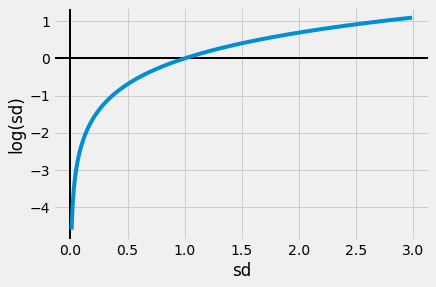

In [ ]:
sd = np.arange(0, 3.0, 0.01)
log_sd = np.log(sd)
fig, ax = plt.subplots()
ax.axhline(y=0, linewidth=2, color='black')
ax.axvline(x=0, linewidth=2, color='black')
ax.plot(sd, log_sd)
ax.set(xlabel='sd', ylabel='log(sd)')
plt.show()

## Define Training and Testing

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


# vae cost function as negative ELBO
def vae_cost(model, x_true, analytic_kl=True, kl_weight=0.5):
    mu, sd = model(x_true, "encode")
    z_sample = model.reparameterize(mu, sd)
    x_recons_logits = model(z_sample, "decode")
    
    # compute cross entropy loss for each dimension of every datapoint (pixel).
    # This tells us the negative log likelihood of a pixel given the encoding
    # so - log p(x|z)
    # The negative log likelihood is the first part of our ELBO loss
    # it gives us feedback about how well the en- and decoding worked
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits)  

    # compute cross entropy loss for all instances in mini-batch; shape=(batch_size,)
    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])

    # compute reverse KL divergence, either analytically 
    # or through MC approximation with one sample
    # The KL divergence is the second part of the elbo loss
    # it keeps the  “distance” between prior p(z) and posterior distribution p(z|x) 
    # of the embedding in check
    # We can manage how hard this distance should be punished by changing kl_weight
    if analytic_kl:
        kl_divergence = - 0.5 * tf.math.reduce_sum(
            1 + tf.math.log(tf.math.square(sd)) - tf.math.square(mu) - tf.math.square(sd),
            axis=1)  # shape=(batch_size, )
    else:
        logpz = normal_log_pdf(z_sample, 0., 1.)  # shape=(batch_size,)
        logqz_x = normal_log_pdf(z_sample, mu, tf.math.square(sd))  # shape=(batch_size,)
        kl_divergence = logqz_x - logpz
    elbo = tf.math.reduce_mean(-kl_weight * kl_divergence - neg_log_likelihood)  
    return -elbo


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = vae_cost(model, x)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss



def test(model, test_data):
    # Test over complete test data

    test_loss_aggregator = []

    for x in test_data:
        mean, logvar = model(x, "encode")
        z = model.reparameterize(mean, logvar)
        x_logit = model(z, "decode")
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)

        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        sample_test_loss = -tf.reduce_mean(logpx_z + logpz - logqz_x)
        test_loss_aggregator.append(sample_test_loss.numpy())

    test_loss = np.mean(test_loss_aggregator)

    return test_loss


def generate_image(model, test_sample):
    mean, logvar = model(test_sample, "encode")
    z = model.reparameterize(mean, logvar)
    return model.sample(z)

## Train model and observe progress

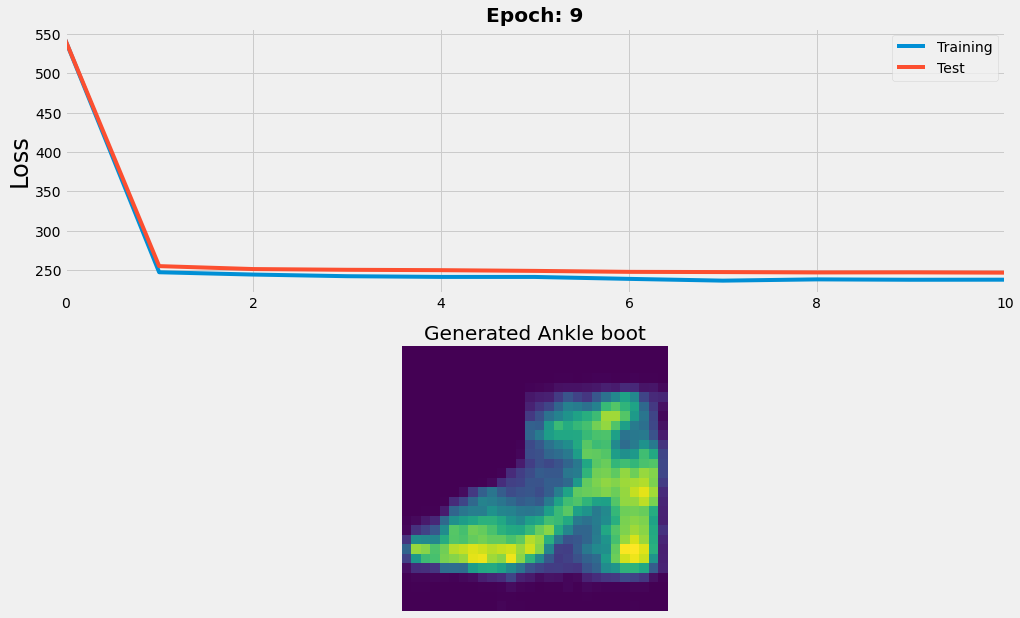

Train loss:  237.75287757488093
Test loss:  246.68549


In [ ]:
#%%time
tf.keras.backend.clear_session()
from IPython.display import clear_output

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
embedding_size = 10
running_average_factor = 0.95

model_var = VarAE(embedding_size)

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []

# Testing model performance on train and test data before learning
train_loss = test(model_var, train_dataset)
train_losses.append(train_loss)


test_loss = test(model_var, test_dataset)
test_losses.append(test_loss)

# Train loop for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    # Training
    running_average_loss = 0
    for image in train_dataset:
        train_loss = np.mean(train_step(model_var, image, optimizer))
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        
    train_losses.append(running_average_loss)
   

    # Testing
    test_loss = test(model_var, test_dataset)
    test_losses.append(test_loss)

   # each epoch we sample 1 image from out test_images
    # and compare it to the models en- and decoding
    index = np.random.choice(len(test_images))
    test_sample = test_images[index]
    generated_image = model_conv(np.expand_dims((test_sample/255), axis=(0, -1))).numpy().squeeze()
    label = class_names[test_labels[index]]

    clear_output(wait=True) 
    fontsize=24

    fig = plt.figure(figsize = (15,10))

    loss_plot = fig.add_subplot(2,1,1)
    loss_plot.set_xlim((0,num_epochs))
    loss_plot.plot(train_losses,label="Training")
    loss_plot.plot(test_losses,label="Test")
    loss_plot.set_ylabel("Loss",fontsize=fontsize)
    loss_plot.set_title("Epoch: " + str(epoch), fontweight="bold")
    loss_plot.legend()

    generated_plot = fig.add_subplot(2,1,2)
    generated_plot.imshow(generated_image)
    generated_plot.set_title("Generated "+ label)
    generated_plot.axis("off")


    plt.show()

    print('Train loss: ',running_average_loss)
    print('Test loss: ',test_loss)


In [ ]:
model_var.summary()

Model: "var_ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  8704      
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  1179904   
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  295040    
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  73792     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5140      
_________________________________________________________________
input_1 (InputLayer)         [(None, 10)]              0    

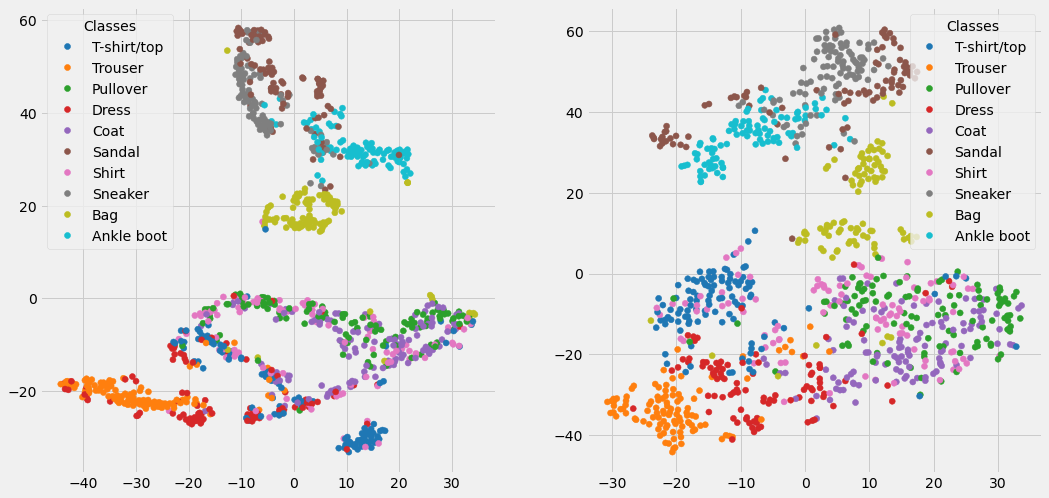

In [ ]:
# Import t-SNE
from sklearn.manifold import TSNE

# Create embedding for first 1000 test images
embedded_images_simple = model_conv(np.expand_dims(test_images[:1000]/255,(-1)).astype(np.float32), "encode")
embedded_images_variational = np.array(model_var(np.expand_dims(test_images[:1000]/255,(-1)).astype(np.float32), "encode"))
z_samples = [model_var.reparameterize(mean, logvar) for (mean, logvar) in zip(embedded_images_variational[0], embedded_images_variational[1])]

tsne = TSNE(n_components=2)
autoencoder_tsne_simple = tsne.fit_transform(embedded_images_simple)
autoencoder_tsne_variational = tsne.fit_transform(z_samples)

fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
scatter=plt.scatter(autoencoder_tsne_simple[:,0],
                   autoencoder_tsne_simple[:,1],
                   c=test_labels[:1000],
                   cmap='tab10'
                  )
# Of course having labels inside the scatter function working like color would be to easy for matplotlib...👌
plt.legend(handles=scatter.legend_elements()[0], title="Classes", labels=class_names)
plt.subplot(1,2,2)
scatter=plt.scatter(autoencoder_tsne_variational[:,0],
                   autoencoder_tsne_variational[:,1],
                   c=test_labels[:1000],
                   cmap='tab10'
                  )

plt.legend(handles=scatter.legend_elements()[0], title="Classes", labels=class_names)
plt.show()

## Interpolation between 2 classes

In [187]:
%%capture
fig = plt.figure(figsize=(6,6))

# get embedding of 2 classes
index_1 = np.random.choice(len(test_labels))
index_2 = np.random.choice(len(test_labels))

# make sure we get samples from different classes
while test_labels[index_1] == test_labels[index_2]:
  index_2 = np.random.choice(len(test_labels))

image_1 = test_images[index_1]
image_2 = test_images[index_2]
label_1 = test_labels[index_1]
label_2 = test_labels[index_2]

embedding_1 = model_conv(np.expand_dims((image_1/255), axis=(0, -1)), "encode").numpy()
embedding_2 = model_conv(np.expand_dims((image_2/255), axis=(0, -1)), "encode").numpy()

difference = embedding_2 - embedding_1

# compute interpolated image plots
interpolation_plots = []

for i in range(101):
  title_txt = str(100-i) + "% " + class_names[label_1] + "   " +  str(i) + "% " + class_names[label_2]
  title = plt.text(0.5, 1.7, title_txt, horizontalalignment='center', verticalalignment='top', transform=ax.transAxes, fontsize = 24)
  interpolation_plots.append([plt.imshow(model_conv(embedding_1 + (i/100)*difference , "decode").numpy().squeeze(),  animated=True), title])
 
plt.axis("off")
anim = animation.ArtistAnimation(fig, interpolation_plots, interval=50, blit=True, repeat_delay=100)

In [188]:
anim